In [1]:
import pandas as pd
import numpy as np
import os
import tensorflow.keras
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

In [2]:
hyper_dim = 500

In [3]:
# we will create base model i.e pre-trained model
#include_top: whether to include the fully-connected layer at the top of the network.
base_model = MobileNet(weights = 'imagenet',input_shape = (224,224,3),include_top = False)
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 225, 225, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 112, 112, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
_________________________________________________________________
conv

In [4]:
len(base_model.layers)

87

In [5]:
#Now will add more layers to base model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation = 'relu')(x)
x = Dense(1024, activation = 'relu')(x)
pred = Dense(3, activation = 'softmax')(x)

In [6]:
# will look for layers, which we can train
for i,layer in enumerate(base_model.layers):
    print(i, layer.name)
    

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [7]:
# create a model with base model layers + new added layers
model = Model(inputs = base_model.input,outputs = pred) # base_model.input specify shapes

for layer in model.layers[:20]:
    layer.trainable = False
for layer in model.layers[20:]:
    layer.trainable = True

    

In [8]:
# added layers can be observed 
for i,layer in enumerate(model.layers):
    print(i, layer.name)
    

0 input_1
1 conv1_pad
2 conv1
3 conv1_bn
4 conv1_relu
5 conv_dw_1
6 conv_dw_1_bn
7 conv_dw_1_relu
8 conv_pw_1
9 conv_pw_1_bn
10 conv_pw_1_relu
11 conv_pad_2
12 conv_dw_2
13 conv_dw_2_bn
14 conv_dw_2_relu
15 conv_pw_2
16 conv_pw_2_bn
17 conv_pw_2_relu
18 conv_dw_3
19 conv_dw_3_bn
20 conv_dw_3_relu
21 conv_pw_3
22 conv_pw_3_bn
23 conv_pw_3_relu
24 conv_pad_4
25 conv_dw_4
26 conv_dw_4_bn
27 conv_dw_4_relu
28 conv_pw_4
29 conv_pw_4_bn
30 conv_pw_4_relu
31 conv_dw_5
32 conv_dw_5_bn
33 conv_dw_5_relu
34 conv_pw_5
35 conv_pw_5_bn
36 conv_pw_5_relu
37 conv_pad_6
38 conv_dw_6
39 conv_dw_6_bn
40 conv_dw_6_relu
41 conv_pw_6
42 conv_pw_6_bn
43 conv_pw_6_relu
44 conv_dw_7
45 conv_dw_7_bn
46 conv_dw_7_relu
47 conv_pw_7
48 conv_pw_7_bn
49 conv_pw_7_relu
50 conv_dw_8
51 conv_dw_8_bn
52 conv_dw_8_relu
53 conv_pw_8
54 conv_pw_8_bn
55 conv_pw_8_relu
56 conv_dw_9
57 conv_dw_9_bn
58 conv_dw_9_relu
59 conv_pw_9
60 conv_pw_9_bn
61 conv_pw_9_relu
62 conv_dw_10
63 conv_dw_10_bn
64 conv_dw_10_relu
65 conv_pw_10

In [9]:
# every keras model has specific input requirement, preprocess_input is used for that
train_datagen =ImageDataGenerator(preprocessing_function = preprocess_input)
val_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
train_set = train_datagen.flow_from_directory('landscape',
                                             target_size = (224,224),batch_size = 15,color_mode = 'rgb',
                                             class_mode = 'categorical')
val_set = val_datagen.flow_from_directory('val',
                                          target_size = (224,224),batch_size = 5,color_mode = 'rgb',
                                          class_mode = 'categorical')

Found 221 images belonging to 3 classes.
Found 126 images belonging to 3 classes.


In [10]:
model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics= ['accuracy'])

In [22]:
results = model.fit_generator(train_set,
                             steps_per_epoch = len(train_set),
                             epochs = 7,
                             validation_data = val_set,
                             validation_steps = len(val_set))

Epoch 1/7
15/15 [==============================] - 83s 6s/step - loss: 0.1322 - acc: 0.9638 - val_loss: 9.2509 - val_acc: 0.2619
Epoch 2/7
15/15 [==============================] - 80s 5s/step - loss: 0.0957 - acc: 0.9683 - val_loss: 7.6164 - val_acc: 0.2857
Epoch 3/7
15/15 [==============================] - 80s 5s/step - loss: 0.0731 - acc: 0.9819 - val_loss: 2.8215 - val_acc: 0.5794
Epoch 4/7
15/15 [==============================] - 81s 5s/step - loss: 0.3421 - acc: 0.9005 - val_loss: 0.8918 - val_acc: 0.7302
Epoch 5/7
15/15 [==============================] - 76s 5s/step - loss: 0.1862 - acc: 0.9457 - val_loss: 1.4891 - val_acc: 0.6905
Epoch 6/7
15/15 [==============================] - 74s 5s/step - loss: 0.0880 - acc: 0.9774 - val_loss: 1.1046 - val_acc: 0.7698
Epoch 7/7
15/15 [==============================] - 74s 5s/step - loss: 0.1118 - acc: 0.9593 - val_loss: 0.7576 - val_acc: 0.8254


In [23]:
results.history

{'loss': [0.1338991458565671,
  0.09684978724284544,
  0.0709832259517045,
  0.347229065449921,
  0.1877507880831567,
  0.08536300505722169,
  0.10671879686768129],
 'acc': [0.9638009,
  0.9683258,
  0.98190045,
  0.9004525,
  0.94570136,
  0.97737557,
  0.959276],
 'val_loss': [9.250892928013435,
  7.616437801947961,
  2.8214944076607935,
  0.8917856747642733,
  1.4891197287764113,
  1.104557009875302,
  0.7576082613419343],
 'val_acc': [0.26190478,
  0.2857143,
  0.5793651,
  0.73015875,
  0.6904762,
  0.76984125,
  0.82539684]}

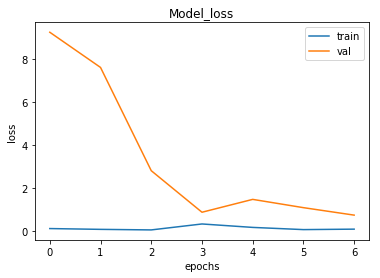

In [26]:
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('Model_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

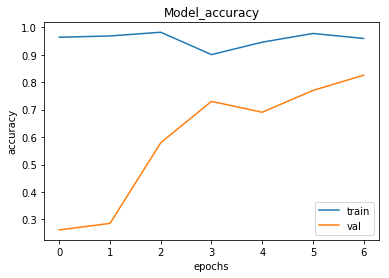

In [24]:
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('Model_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend(['train','val'])
plt.show()

In [19]:
len(train_set)

15

In [13]:
a=train_set[1]

In [14]:
#test_datagen = ImageDataGenerator(preprocessing_function = preprocess_input)
test_set = train_datagen.flow_from_directory('test',
                                             target_size = (224,224),batch_size = 1,color_mode = 'rgb',
                                             class_mode = None)

Found 4 images belonging to 1 classes.


In [15]:
train_set.class_indices

{'Beaches': 0, 'Desert': 1, 'Mountains': 2}

In [16]:
from keras.preprocessing.image import array_to_img
import matplotlib.pyplot as plt

Using TensorFlow backend.


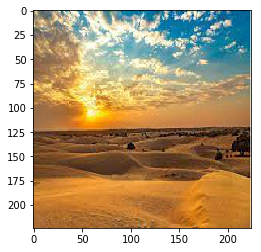

Desert


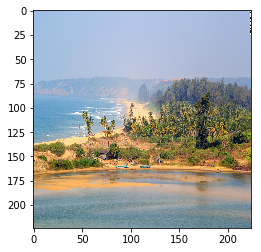

Beaches


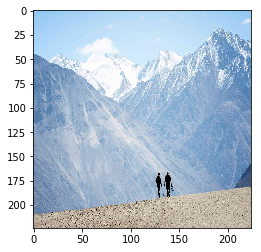

Mountains


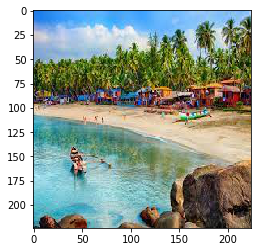

Beaches


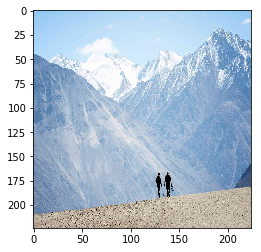

Mountains


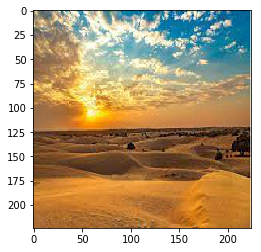

Desert


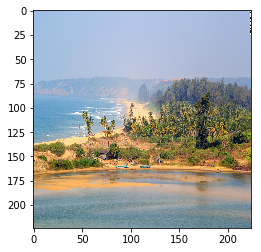

Beaches


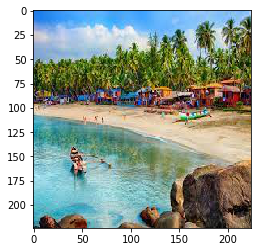

Beaches


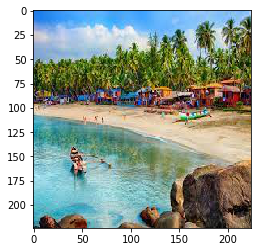

Beaches


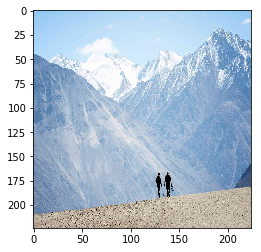

Mountains


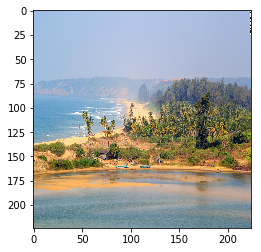

Beaches


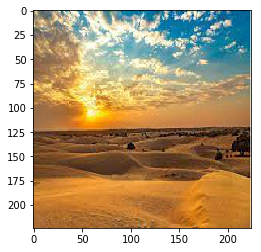

Desert


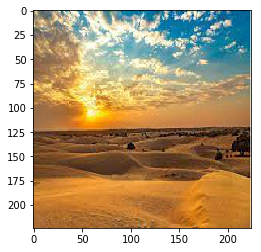

Desert


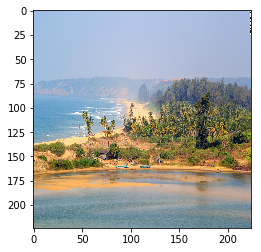

Beaches


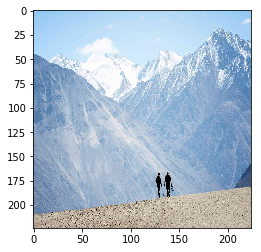

Mountains


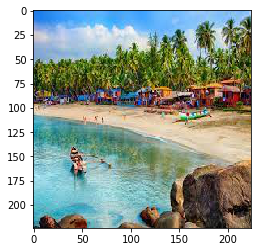

Beaches


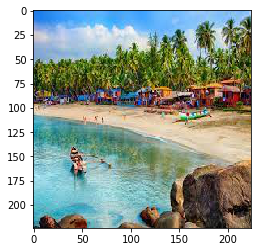

Beaches


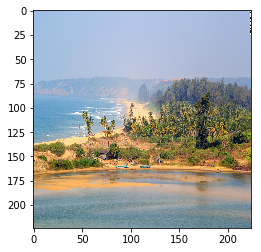

Beaches


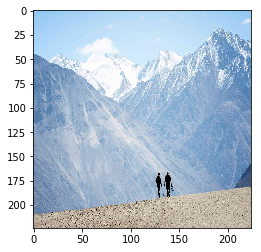

Mountains


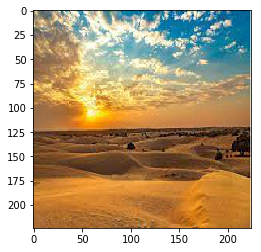

Desert


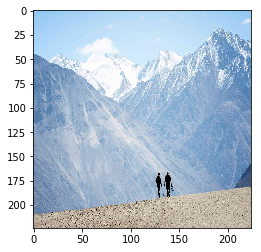

Mountains


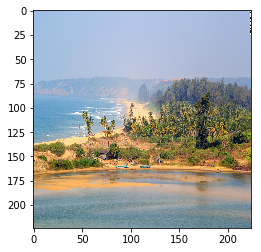

Beaches


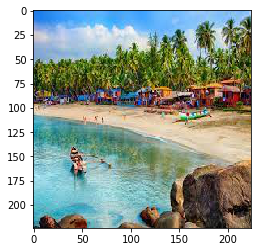

Beaches


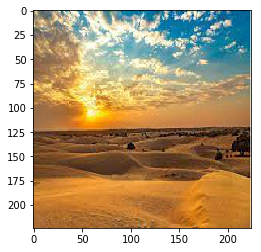

Desert


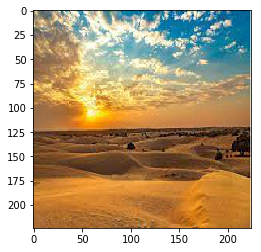

Desert


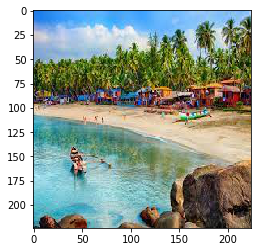

Beaches


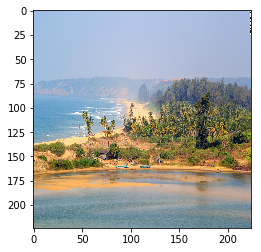

Beaches


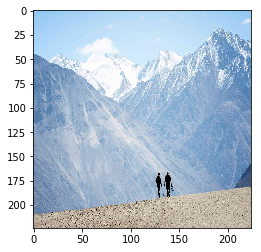

Mountains


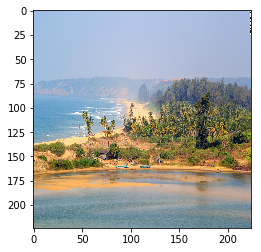

Beaches


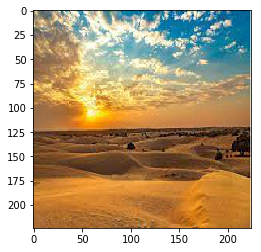

Desert


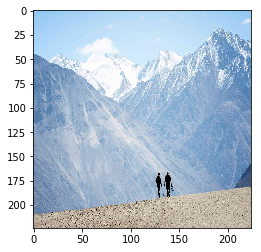

Mountains


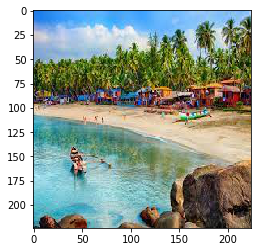

Beaches


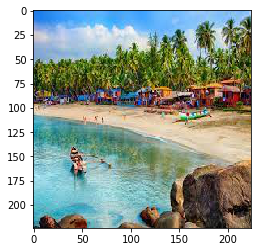

Beaches


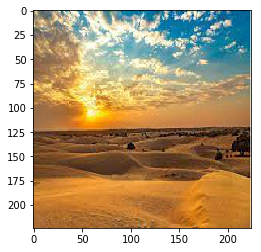

Desert


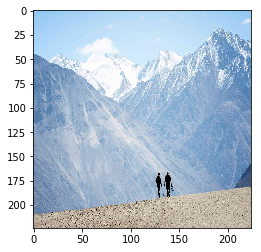

Mountains


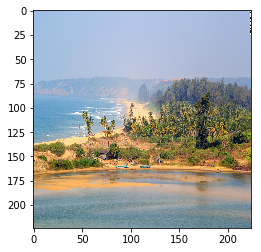

Beaches


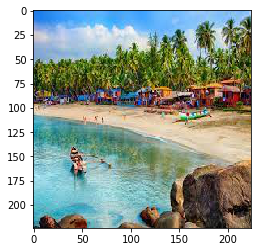

Beaches


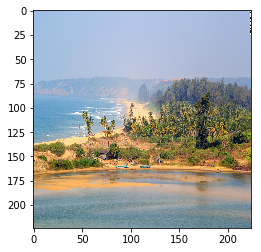

Beaches


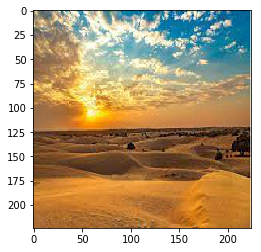

Desert


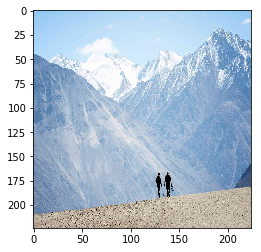

Mountains


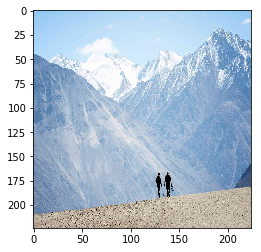

Mountains


KeyboardInterrupt: 

In [52]:
class_names = ['Beaches','Desert','Mountains'] # For second model, we can't use model.predict_classes
class_out = []
for i in test_set:
    pred = model.predict(i)
    image = array_to_img(i[0])
    plt.imshow(image)
    plt.show()
    
    
    class1 = class_names[int(np.argmax(pred,axis = 1))]
    class_out.append(class1)
    print(class1)
#     print(inv_map[pred2])


In [20]:
pred = model.predict(i)
class_names[int(np.argmax(pred,axis = 1))]


'Mountains'

In [52]:
print(pred2)

2
